In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# time series forecasting tutorial

Forecasting is used in a wide variety of contexts to anticipate future outcomes over a range of time horizons — hourly electricity consumption, daily precipitation totals, quarterly product demand, etc. — and plan accordingly. The predictability of an event or value depends on how well we understand its causes, how much information is available in advance, and whether the forecast affects the outcome itself. Good forecasts identify and extrapolate meaningful patterns and relationships from past information while ignoring random/atypical variation.

In this tutorial, we'll focus on time series forecasting: the use of numerical, sequential data collected at regular intervals over time in order to predict future observations. Simple models rely only on historical values of the target variable, while more complex "mixed" models also incorporate relevant predictor variables; as always, selecting an appropriate model depends on context.

Any given forecasting task consists of the following steps:

1. **problem definition**: Defining how a forecast will be used, by whom, and for what purpose.
2. **information gatherinng**: Acquiring sufficient data and domain expertise to produce a good forecast.
3. **exploratory data analysis**: Developing an understanding of the data's broad contours, eccentricities, and key attributes through graphs and statistics.
4. **model selection and fitting** Choosing a model based on the data and use case, and fitting it to the available data.
5. **model evaluation**: Assessing the quality of the fit model's forecasts on new or held-out data.

Then, of course, putting the model and its forecasts to use!

## 1. problem definition

Climate change is a large and growing existential threat to life on our planet. According to scientific consensus, human-caused emission of greenhouse gasses (GHGs) into the atmosphere is the dominant driver of these changes. Can we predict future atmospheric GHG concentrations over the course of the next ten years, assuming humanity doesn't dramatically change course, in order to show where "business as usual" will get us?

## 2. information gathering

Different GHGs affect the atmosphere and climate differently, depending on their concentration, longevity, and heat-trapping potential. The large majority of anthropogenic GHG emissions are in the form of carbon dioxide (CO2), produced by burning fossil fuels (coal, gas, oil) and some chemical reactions (e.g. cement manufacture) [[source](https://www.epa.gov/ghgemissions/overview-greenhouse-gases)]. Plus, it's the most well-known and -studied of the bunch. Since humanity has been changing the concentration relatively slowly over the course of many years, we want a time series dataset of atmospheric CO2 concentrations spanning at least a couple of decades.

The Mauna Loa Observatory has been taking high-quality and well-validated measurements of atmospheric CO2 concentrations since the 1950s [[source](https://www.esrl.noaa.gov/gmd/ccgg/about/co2_measurements.html)], and that data is readily available from the [Scipps Institution of Oceanography](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html) or [National Oceanic and Atmospheric Administration](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html). Turns out we've been using the term "concentration" loosely: values are actually "mole fractions" in units of parts-per-million (ppm), defined as the number of CO2 molecules in a given number of air molecules after removal of water vapor.

Lastly, it's worth noting that our forecast will not be "good" because it violates a couple key assumptions: that humanity will do nothing to change its GHG emissions over the next decade, and that the forecast won't affect the outcome. Although emissions aren't decreasing nearly fast enough, recent technological and political progress signify that big changes are already underway. Also, governments / scientists have been making forecasts like this for years in order to influence our emissions trajectory, and I'm doing the same thing (albeit with a much smaller influence). Still, it's a nice subject for a tutorial.

### technical setup

```
$ git clone git@github.com:bdewilde/time-series-forecasting-study.git
$ cd time-series-forecasting-study
$ pip install -e .
$ pip install -e .[dev]
```

### data acquisition

First, let's download daily in-situ CO2 concentration measurements from 1958 – Present, via Scipps. We leave the "raw" dataset as-is, except for skipping the first ~30 rows, where the researchers have included dataset metadata that breaks the CSV format.

In [3]:
import time_series_forecasting_study

In [4]:
data_orig = time_series_forecasting_study.datasets.load_mlo_co2()
data_orig

,% Yr,Mn,Dy,CO2,NB,scale
0,1958,1,1,NaN,0,8.1
1,1958,1,2,NaN,0,8.1
2,1958,1,3,NaN,0,8.1
3,1958,1,4,NaN,0,8.1
4,1958,1,5,NaN,0,8.1
...,...,...,...,...,...,...
23037,2021,1,27,NaN,0,8.1
23038,2021,1,28,NaN,0,8.1
23039,2021,1,29,NaN,0,8.1
23040,2021,1,30,NaN,0,8.1


### data wrangling

We have to tidy and transform — "wrangle" — this raw dataset to get it into analysis-ready form.

- clean up column names and assign correct data types
- combine datetime components into a single datetime column
- drop unnecessary columns
- resample the frequency of observations, as desired
- handle missing values by filling (forward or via interpolation) and dropping rows that can't be filled

Under the hood, this is all done in `pandas`. Let's resample to monthly frequency data, since our forecast's time horizon is _years_ and this should smooth out some of the random fluctuation in the daily measurements. (Also, as we'll see, the data have a seasonal component that can be split neatly into months.) Let's also interpolate any missing values rather than forward fill, since we can reasonably expect the values to change smoothly from month to month.

In certain cases, we might also like to transform the values in order to remove known sources of variation and thereby simplify the data before modeling. For example, we might normalize values that depend on population by total population to get per-capita equivalents, or adjust financial data by inflation to make fairer comparisons of absolute amounts. In this case, however, we should be fine as-is: Our monthly values are averaged over constituent days, so we don't have to adjust for the oddities of our calendar such as months having different numbers of days.

In [5]:
# if curious, take a peak at the source code
# time_series_forecasting_study.datasets.munge_mlo_co2??

In [6]:
data = time_series_forecasting_study.datasets.munge_mlo_co2(data_orig, freq="MS", fill="interpolate")
data

,CO2
dt,
1958-03-01,316.425
1958-04-01,317.438462
1958-05-01,317.471111
1958-06-01,316.598142
1958-07-01,315.753333
...,...
2020-09-01,411.315385
2020-10-01,411.292143
2020-11-01,413.000345


## 3. exploratory data analysis

Our dataset is simple: it consists of just one dependent variable (`"CO2"`) measured at a sequence of datetimes, without any gaps or fundamental changes in the underlying process producing these values. Fortunately, this makes it straightforward to work with!

The goal of exploratory data analysis is to get acquainted with the important and relevant characteristics of a dataset through graphs and statistics — and, in this particular task, to facilitate better forecasting in step 4.

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

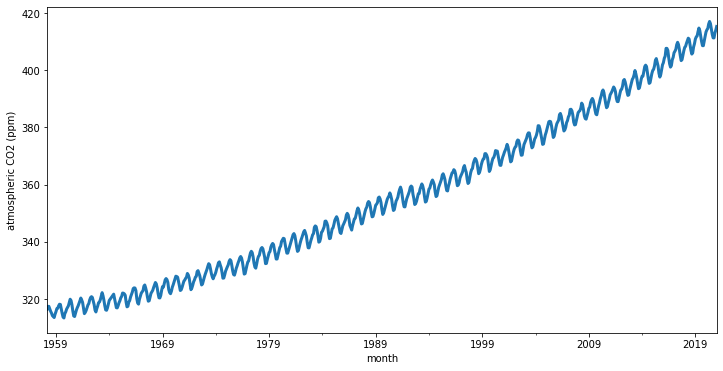

In [8]:
_ = data["CO2"].plot.line(xlabel="month", ylabel="atmospheric CO2 (ppm)", lw=3, figsize=(12, 6))

In this time plot, we can see a clear and increasing trend — which scientists have attributed to human activity. We also see regular variation at yearly intervals comprised of 12 monthly observations apiece, which arise from natural processes like the seasonal growth and decay of plants (dominated by the northern hemisphere, which has a larger land biosphere than the southern) [[source](https://svs.gsfc.nasa.gov/4565)]. Changes are smooth, without any apparent discontinuities or outlier values. Seems like a simple time series, which should make modeling it more straightforward.

One thing does catch my eye: It looks like the overall trend may be non-linear — that is, increasing in slope over time rather than just a straight line. Let's plot annual percent changes over time to check:

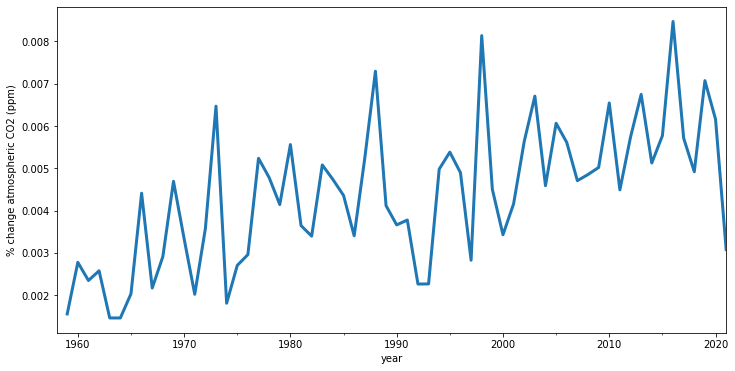

In [9]:
_ = data["CO2"].resample("Y").mean().pct_change().plot.line(
    xlabel="year", ylabel="% change atmospheric CO2 (ppm)", lw=3,
    figsize=(12, 6),
)

Yup, looks like CO2 concentrations have increased at an increasing rate, though _maybe_ they're stating to level off. Yikes! Emissions aren't just going in the wrong direction, they're going their faster than before...

We can also take a closer look at the repeating annual pattern using a "seasonal plot", which takes each season's observations and plots them one on top of the other rather than one after the other as in the time plot above. I've taken some artistic liberty and colored each year's observations to suggest the corresponding change in global temperature.

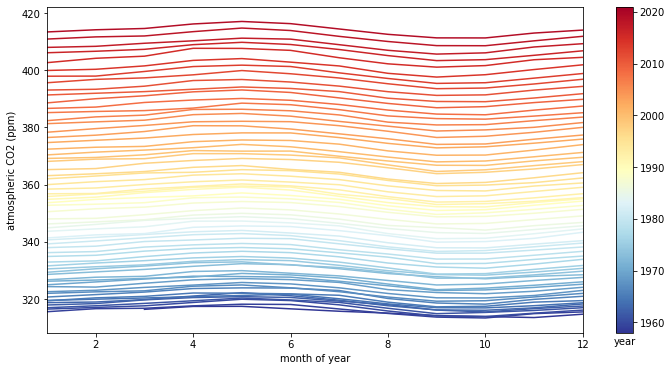

In [10]:
data_grped = data.groupby(by=data.index.year)

fig, ax = plt.subplots(figsize=(12, 6))
cmap = plt.cm.get_cmap(name="RdYlBu_r")
cmap_norm = mpl.colors.Normalize(vmin=data.index.year.min(), vmax=data.index.year.max())
for i, (year, grp) in enumerate(data_grped):
    ax.plot(grp.index.month, grp.values, color=cmap(i / len(data_grped)), label=year)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=cmap_norm, cmap=cmap), ax=ax)
cbar.ax.set_xlabel("year")
_ = ax.set_ylabel("atmospheric CO2 (ppm)")
_ = ax.set_xlabel("month of year")
_ = ax.set_xlim(left=1, right=12)

We can see that annual atmospheric CO2 concentrations are highest around May and lowest around October, which clearly reflects the role of growing plants in removing CO2 and decaying plants in emitting it.

We should also inspect the distribution of values for our target variable.

In [11]:
data.describe()

,CO2
count,755.000000
mean,355.752502
std,29.132317
min,313.402222
25%,329.183483
50%,352.782759
75%,379.302373
max,417.049231


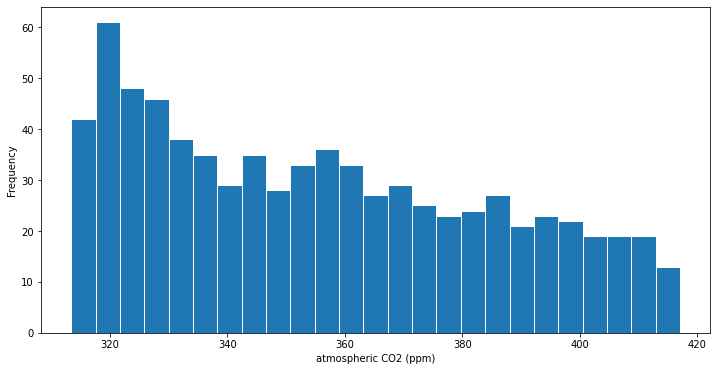

In [12]:
ax = data["CO2"].plot.hist(bins=25, ec="white", figsize=(12, 6))
_ = ax.set_xlabel("atmospheric CO2 (ppm)")

As we might've guessed, the values are not normally distributed.

If our dataset had included multiple predictor variables, we would also want to inspect and quantify the relationships between the variables; fortunately, `pandas` makes this easy! We could use a scatterplot matrix to visualize each pairwise relationship: `pd.plotting.scatter_matrix(data, diagonal="hist")` [[link](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#scatter-matrix-plot)]. Correlation coefficients measure the _linear_ relationship between variables, so can be potentially misleading; but again, `pandas` comes through: `data.corr(method="spearman")`.

In [13]:
data.corr(method="spearman")  # not useful here :)

,CO2
CO2,1.0


Similarly, "autocorrelation" measures the linear relationship between _lagged_ values in a time series. Autocorrelation coefficients are typically computed at multiple lags, from `k = 1` (comparing values to the immediately preceding values) on up. It's common to plot these values all together in a "correlogram".

In [14]:
sm.tsa.acf(data["CO2"], nlags=12, fft=True)

array([1.        , 0.99511587, 0.98917429, 0.98290129, 0.97709853,
       0.97202372, 0.96765994, 0.96390371, 0.9608121 , 0.95839987,
       0.95647838, 0.95432306, 0.95100126])

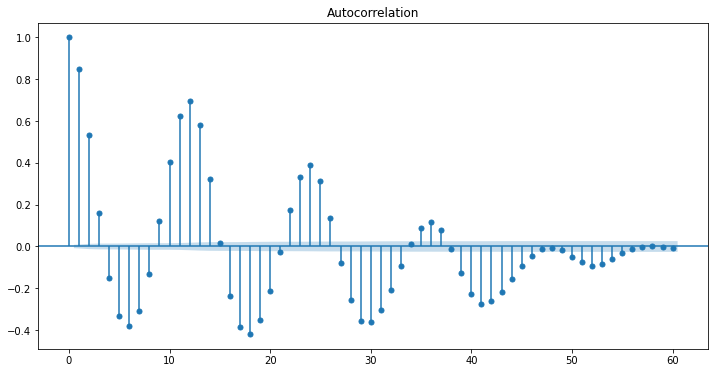

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
# note that both statsmodels and pandas include functionality for plotting autocorrelations
# _ = pd.plotting.autocorrelation_plot(data["CO2"].head(12 * 5), ax=ax)
_ = sm.graphics.tsa.plot_acf(data["CO2"].head(12 * 5 + 1), lags=12 * 5, fft=True, alpha=0.95, use_vlines=True, ax=ax)

From this, we can see that

- autocorrelations are higher at small lags and slowly decrease, which is indicative of a trend in the data
- autocorrelations are higher at multiples of a particular lag value (`k` of 12, 24, 36, ... months), which corresponds to the seasonal component's frequency

### decomposition

So far, I've tossed around terms like "trend" and "seasonality" loosely, but these actually have technical definitions and applications that merit discussion. Time series data can exhibit different types of patterns that may have different underlying causes; in fact, time series may be split into the corresponding components:

- **trend:** Long-term change of the dependent variable over time (e.g. the stock market increasing in good economic times and decreasing in bad... at least, back when the two were closely linked). It may encompass a "cyclic" component of slow ups/downs without a regular frequency (e.g. the "business cycle"), which is not to be confused with the seasonal component.
- **seasonal:** Repeating ups/downs with a regular frequency, owing to some property of the system (e.g. daily patterns in surface air temperature, weekly patterns in web site visitor traffic, annual patterns in energy consumption).
- **residual:** Everything left over, including random noise.

Certain use cases / forecasting models benefit from "de-trended" or "seasonally-adjusted" time series, but it's also just a useful way to better understand the data.

#### moving averages

A simple method for estimating trend is through the calculation of averages over a sliding window containing multiple observations. The window's size is typically a positive odd number (odd so that the window is _symmetric_ about the center point), but it's possible to make an even-order moving average symmetric by taking a moving average twice. In our case, based on the time and autocorrelation plots above, we know that our data exhibits annual seasonality (i.e. a period of 12 monthly observations), so let's use a 2 x 12-MA.

Moving averages may be weighted by some window function, e.g. exponential or gaussian decay about the window's center point, to produce smoother estimates, but for simplicity let's keep it unweighted.

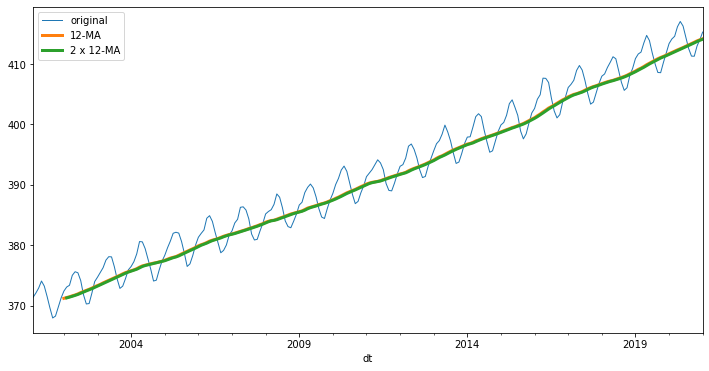

In [16]:
ax = data["CO2"].tail(12 * 20).plot.line(lw=1, figsize=(12, 6), label="original")
_ = data["CO2"].tail(12 * 20).rolling(window=12).mean().plot.line(ax=ax, lw=3, label="12-MA")
_ = data["CO2"].tail(12 * 20).rolling(window=12).mean().rolling(window=2).mean().plot.line(ax=ax, lw=3, label="2 x 12-MA")
leg = ax.legend(loc="best")

#### classical decomposition

This common but simplistic method combines time series components in one of two ways: additively (`y(t) = trend + seasonal + residual`) or multiplicatively (`y(t) = trend * seasonal * residual`), where `y(t)` is the value of the dependent variable at time `t`. If the components don't vary with the level of the data, use an additive decomposition; otherwise, go with multiplicative. Given that our CO2 concentration time series is _increasingly_ increasing year over year, we should probably decompose it multiplicatively.

In short, this method estimates the trend component by computing a moving average, as described above; the seasonal component by averaging de-trended values over all periods; and the residual component by taking the difference between original values and de-trended and -seasonalized values. It has some notable limitations — for example, it assumes that seasonal efects are the same over the entire time series, which may not necessarily be true — but it's a decent starting point.

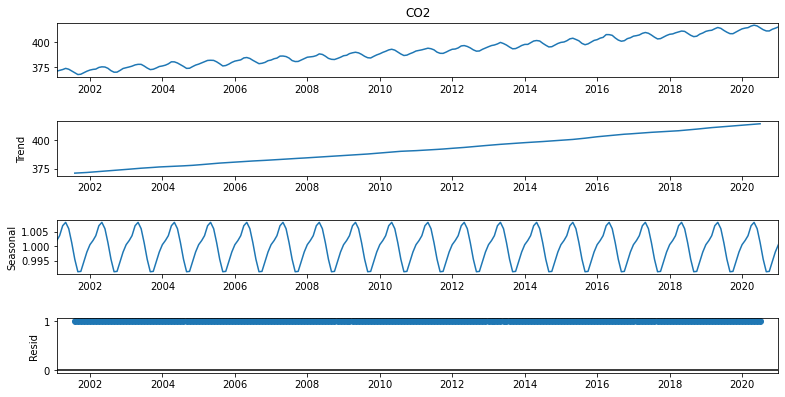

In [17]:
result = sm.tsa.seasonal_decompose(data["CO2"].tail(12 * 20), period=12, model="multiplicative")
fig = result.plot()
fig.set_size_inches(12, 6)

#### Seasonal and Trend decomposition using Loess (STL)

This method relies on LOESS (locally estimated scatterplot smoothing) to extract smooth components. It's flexible and configurable, allows for changes in seasonality over time, and can be robust to outliers. However, it only handles additive decompositions (unless you mathematically transform your time series data on the way in and de-transform the component values on the way out — but this is a complication best set aside, for now).

The most important parameters to set are the length of the seasonal smoother (must be odd) and the length of the trend smoother (~1.5x the seasonal smoother, must also be odd), though there are several other knobs to fiddle.

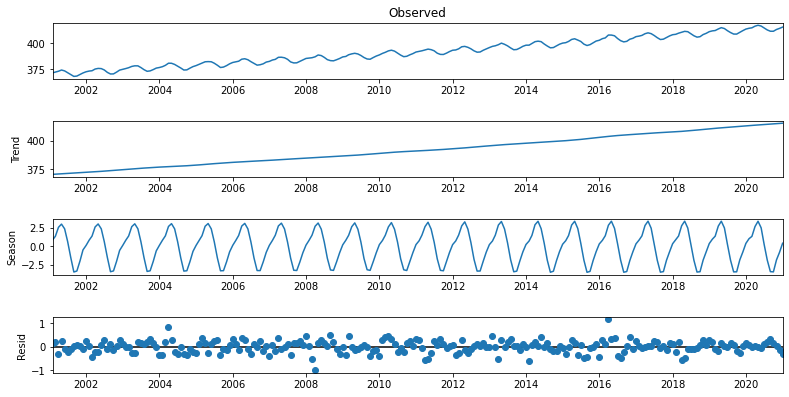

In [18]:
model = sm.tsa.STL(data[["CO2"]].tail(12 * 20), seasonal=13, trend=21, robust=False)
result = model.fit()
fig = result.plot()
fig.set_size_inches(12, 6)

Note how the seasonal component changes slightly over the years.

If you find yourself eyeballing a decomposition plot and can't decide if there's a meaningful trend/seasonal component, it might help to compute a quantitative measure of the "strength" of those components. For data with a strong trend, we assume that the variation in seasonally-adjusted data should be much larger then variation in the residual component alone; an analogous assumption can be made for seasonal strength:

In [19]:
strength_trend = max(1 - result.resid.var() / (result.resid.var() + result.trend.var()), 0)
strength_season = max(1 - result.resid.var() / (result.resid.var() + result.seasonal.var()), 0)
strength_trend, strength_season

(0.9996061040351177, 0.9864145977563041)

(Values close to 0 indicate a weak component, while those close to 1 indicate strong components.)

### stationarity

One final thing to check for is the "stationarity" of a time series: that is, do its statistical properties like mean and variance change over time or stay the same? Many (most?) time series are _not_ stationary because they have a trend / seasonal component or some other time-dependent characteristic, but some forecasting models only work on stationary data. There are mathematical transformations _stationarize_ a time series, but first we need to know if it's necessary. This may be as easy as eye-balling a couple plots:

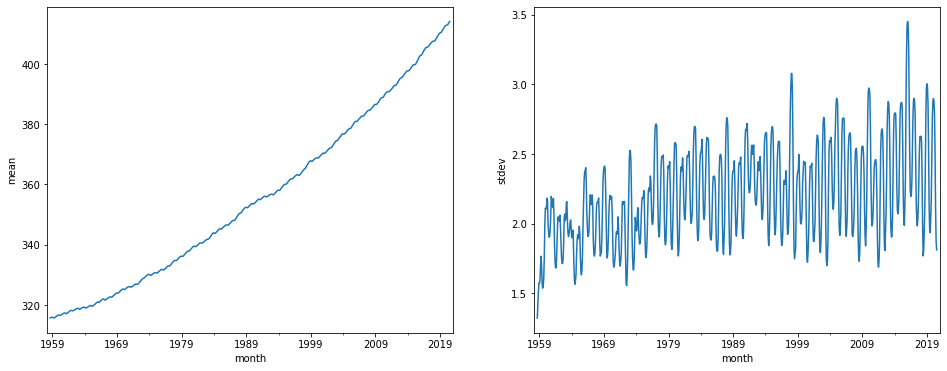

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
_ = data["CO2"].rolling(window=13, center=True).mean().plot.line(ax=axes[0], xlabel="month", ylabel="mean")
_ = data["CO2"].rolling(window=13, center=True).std().plot.line(ax=axes[1], xlabel="month", ylabel="stdev")

Clearly, our data's mean and standard deviation change over time, so we have a non-stationary time series. Sometimes, though, eye-balling it isn't enough. In these cases, we can quantitatively assess stationarity using statistical tests; the most common tests are the Augmented Dickey Fuller ("ADF") and Kwiatkowski-Phillips-Schmidt-Shin ("KPSS") tests.

ADF performs a hypothesis test, where the null hypothesis is that the time series has a "unit root" — basically, how strongly a time series is defined by a trend. Failure to reject the null hypothesis provides evidence that the series is non-stationary.

In [67]:
result = sm.tsa.stattools.adfuller(data["CO2"], regression="ct", autolag="AIC")
adf_stat, pval, lag, nobs, crit_vals, icbest = result
adf_stat, pval

(-0.42069446864641785, 0.9862391512721403)

Since our significance test's p-value is >> 0.05, we've definitely failed to reject the null hypothesis; therefore (and as expected), the data is non-stationary.

Similarly, the KPSS test performs a hypothesis test where the null hypothesis is that the time series is level or trend stationary (note that this is reversed from ADF).

In [75]:
result = sm.tsa.stattools.kpss(data["CO2"], regression="ct", nlags="auto")
kpss_stat, pval, lag, crit_vals = result
kpss_stat, pval

/Users/burtondewilde/.pyenv/versions/3.9.1/envs/forecasting-study/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.0121313435437618, 0.01)

This time, we strongly reject the null hypothesis with a p-value << 0.05, and can again conclude that the series is non-stationary.

In general, it's best to apply both tests, since their combined results give us great confidence in the conclusion, and potential insight into how we should stationarize the data, if required by our forecasting model.

TODO: rework this?
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

## 4. model selection and fitting

So far, we've clearly defined our problem and developed intuitions about our dataset; based on this, we now have to select a suitable forecasting model. Fortunately (or not...), we have _lots_ of options to choose from, with varying pros/cons. Some models are robust to outliers, handle complex seasonality, output prediction intervals, are quick to fit or easy to interpret, etc. In practice, we often explore a couple reasonable models, and ultimately select the one that performs best upon evaluation.

As mentioned early on, modeling univariate vs. multivariate time series datasets is quite different; given our dataset, we'll be choosing from models that forecast future values based on observed patterns in past values. In all cases, though, it's good to have a simple baseline against which to compare.

### naïve methods

In the case of non-seasonal data, a naïve method forecasts all future values as equal to the last observed value; for seasonal data, we instead forecast future values as equal to the last observed value corresponding to the same point in the season. Another method is the "drift" method, in which a straight line is drawn between the first and last observations then projected forward.

Yes, this is _really_ naïve! In most cases these are just benchmarks, but for certain types of time series data these methods can produce surprisingly decent forecasts...

In [353]:
import itertools


def naive_forecast(series: pd.Series, steps: int) -> pd.Series:
    last_dt = series.index[-1]
    last_val = series.iat[-1]
    index = pd.date_range(start=last_dt + series.index.freq, freq=series.index.freq, periods=steps)
    values = [last_val] * steps
    return pd.Series(data=values, index=index, name=series.name)


def naive_seasonal_forecast(series: pd.Series, period: int, steps: int) -> pd.Series:
    last_dt = series.index[-1]
    index = pd.date_range(start=last_dt + series.index.freq, freq=series.index.freq, periods=steps)
    values = list(itertools.islice(itertools.cycle(series.tail(period).tolist()), steps))
    return pd.Series(data=values, index=index, name=series.name)


def drift_forecast(series: pd.Series, steps: int) -> pd.Series:
    # manual implementation of y = m*x + b
    b = series.iat[0]
    dy = series.iat[-1] - series.iat[0]
    dx = (series.index[-1] - series.index[0]).days
    m = dy / dx
    last_dt = series.index[-1]
    index = pd.date_range(start=last_dt + series.index.freq, freq=series.index.freq, periods=steps)
    x = (index - series.index[0]).days
    values = m * x + b
    return pd.Series(data=values, index=index, name=series.name)


# def linear_forecast(series: pd.Series, steps: int) -> pd.Series:
#     poly = (
#         np.polynomial.Polynomial([1, 1])
#         .fit(
#             (series.index.astype("int64") // (10**9)).to_numpy(float),
#             series.to_numpy(float),
#             1
#         )
#     )
#     last_dt = series.index.max()
#     index = pd.date_range(start=last_dt + series.index.freq, freq=series.index.freq, periods=steps)
#     values = [poly(idx) for idx in (index.astype("int64") // (10**9)).to_numpy(int)]
#     return pd.Series(data=values, index=index, name=series.name)

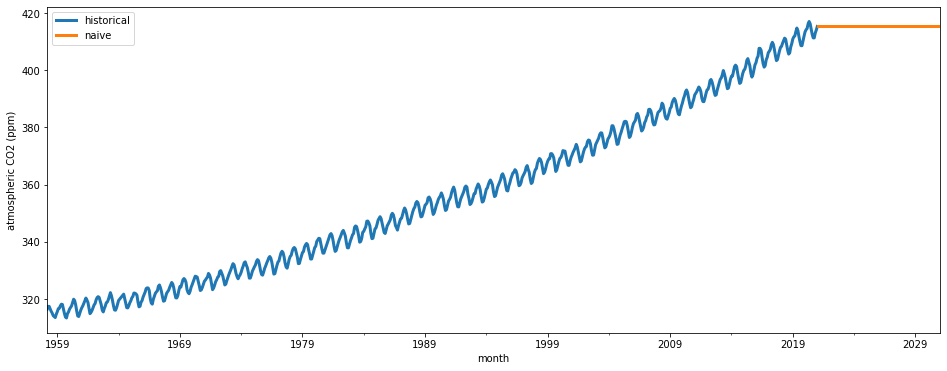

In [354]:
ax = data["CO2"].plot.line(lw=3, xlabel="month", ylabel="atmospheric CO2 (ppm)", figsize=(16, 6), label="historical")
forecast = naive_forecast(data["CO2"], steps=120)
forecast.plot.line(lw=3, ax=ax, label="naive")
leg = ax.legend()

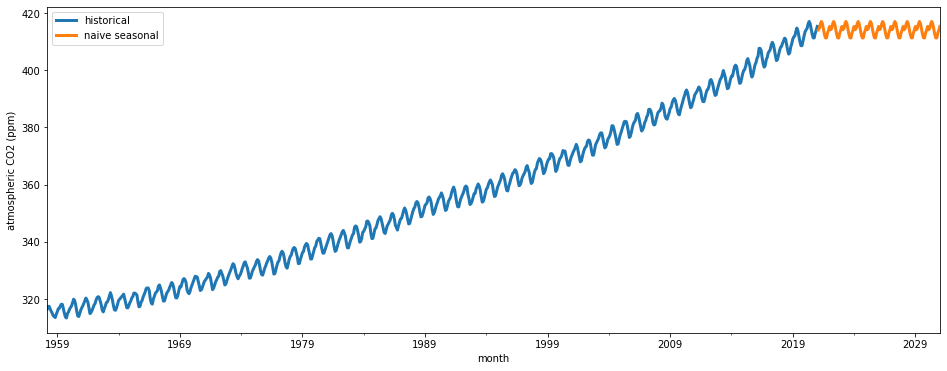

In [355]:
ax = data["CO2"].plot.line(lw=3, xlabel="month", ylabel="atmospheric CO2 (ppm)", figsize=(16, 6), label="historical")
forecast = naive_seasonal_forecast(data["CO2"], period=12, steps=120)
forecast.plot.line(lw=3, ax=ax, label="naive seasonal")
leg = ax.legend()

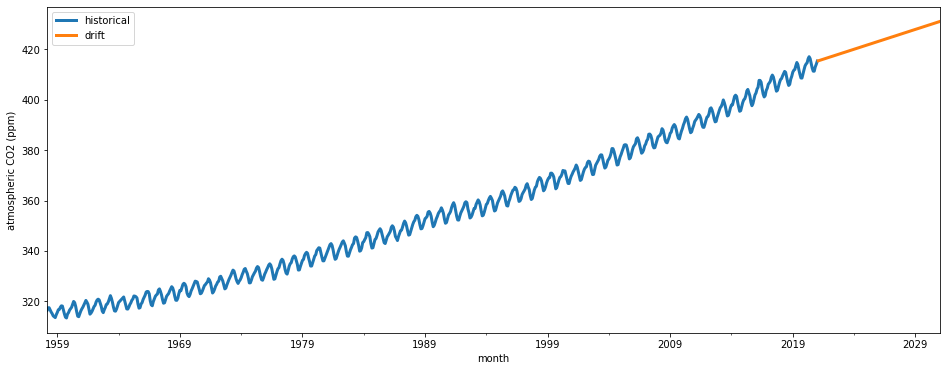

In [356]:
ax = data["CO2"].plot.line(lw=3, xlabel="month", ylabel="atmospheric CO2 (ppm)", figsize=(16, 6), label="historical")
forecast = drift_forecast(data["CO2"], steps=120)
forecast.plot.line(lw=3, ax=ax, label="drift")
leg = ax.legend()

### exponential smoothing models

A family of forecasting models are based on "exponential smoothing" — basically, computing weighted averages of past observations, where weights decay exponentially as the observations get farther back in time. It's a decent, general-purpose method.

#### simple exponential smoothing

This is the simplest version of this approach, and it's suitable for time series data without strong trend or seasonal components. (So, _not_ our dataset — at least, not without a suitable transformation.) Mathematically, this model can be expressed in component form, like so:

- forecast equation: $\hat{y}_{t + h | t} = \ell_{t}$
- smoothing equation: $\ell_{t} = \alpha y_{t} + (1 - \alpha) \ell_{t - 1}$

This model has two key parameters:

- smoothing level $\alpha$: the rate at which weights decay, where $0 \leq \alpha \leq 1$
- initial level $\ell_{0}$: the smoothed value of the series at time $t = 0$, from which subsequent fitted values (one-step forecasts of training data) are generated

The parameters may be initialized manually or inferred from the data; for convenience and reliability, let's have `statsmodels` find optimized values for us.

It's important to note that simple exponential smoothing model produces "flat" forecasts with a value equal to the last level value $\ell_{T}$ fit from the training data, which is why it doesn't work for data with trend or seasonal components.

In [350]:
model = sm.tsa.SimpleExpSmoothing(data["CO2"].astype(float), initialization_method="estimated")
result = model.fit(smoothing_level=None, initial_level=None, optimized=True)
result.summary()

Dep. Variable:,CO2,No. Observations:,755
Model:,SimpleExpSmoothing,SSE,1158.887
Optimized:,True,AIC,327.516
Trend:,None,BIC,336.769
Seasonal:,None,AICC,327.569
Seasonal Periods:,None,Date:,"Tue, 02 Feb 2021"
Box-Cox:,False,Time:,17:20:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,316.42500,l.0,True


In [351]:
forecast = result.forecast(steps=120)

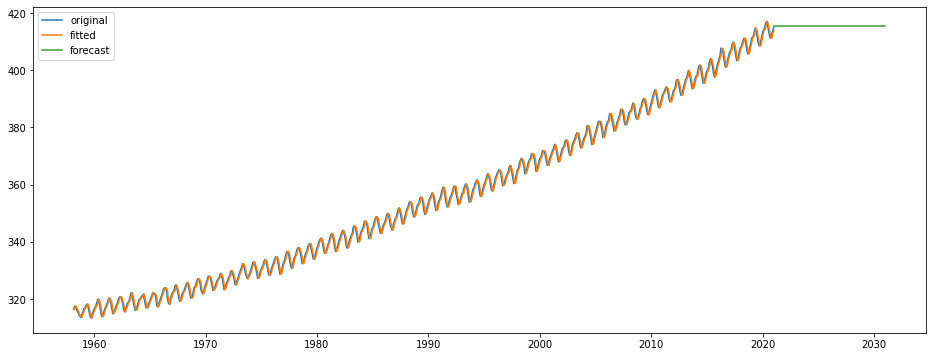

In [352]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(data["CO2"].index, data["CO2"].astype(float), label="original")
ax.plot(data["CO2"].index, result.fittedvalues, label="fitted")
ax.plot(forecast.index, forecast.values, label="forecast")
leg = ax.legend()

Looks similar to our naïve baseline model — that is to say, _not great_ — but fortunately there are extensions of this model that account for trend and seasonality.

#### Holt-Winters seasonal exponential smoothing

This method builds on simple exponential smoothing by adding smoothing equations for the trend and seasonal components, with corresponding smoothing parameters and seasonal period $m$. As we've seen before, this comes in both additive and multiplicative varieties, but we'll just describe the former here. In mathematical form:

- forecast equation: $\hat{y}_{t + h | t} = \ell_{t} + hb_{t} + s_{t + h - m(k + 1)}$
- smoothing equations (for level, trend, and seasonal components, respectively):

$$
\ell_{t} = \alpha (y_{t} - s_{t -m}) + (1 - \alpha)(\ell_{t - 1} + b_{t - 1}) \\
b_{t} = \beta^{*}(\ell_{t} - \ell_{t - 1}) + (1 - \beta^{*})b_{t - 1} \\
s_{t} = \gamma (y_{t} - \ell_{t - 1} - b_{t - 1}) + (1 - \gamma) s_{t - m}
$$

Or, in human-friendlier terms... The level equation represents a weighted average of the seasonally-adjusted observation at time $t$ and the non-seasonal one-step forecast; the trend equation represents a weighted average of the current (time $t$) and previous (time $t - 1$) estimated trends; and the seasonal equation represents a weighted average of the current seasonal index (time $t$) and that of the same point in the previous season (time $t - m$).

In [347]:
model = sm.tsa.ExponentialSmoothing(
    data["CO2"].astype(float),
    trend="additive",
    seasonal="additive",
    seasonal_periods=12,
    initialization_method="estimated",
)
result = model.fit(
    smoothing_level=None,
    smoothing_trend=None,
    smoothing_seasonal=None,
    optimized=True,
)
result.summary()

Dep. Variable:,CO2,No. Observations:,755
Model:,ExponentialSmoothing,SSE,91.617
Optimized:,True,AIC,-1560.368
Trend:,Additive,BIC,-1486.341
Seasonal:,Additive,AICC,-1559.439
Seasonal Periods:,12,Date:,"Tue, 02 Feb 2021"
Box-Cox:,False,Time:,17:20:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5119369,alpha,True
smoothing_trend,0.0130382,beta,True


In [348]:
forecast = result.forecast(steps=120)
# simulations = result.simulate(120, repetitions=100, error="add")
# simulations.quantile(q=[0.1, 0.9], axis="columns").T

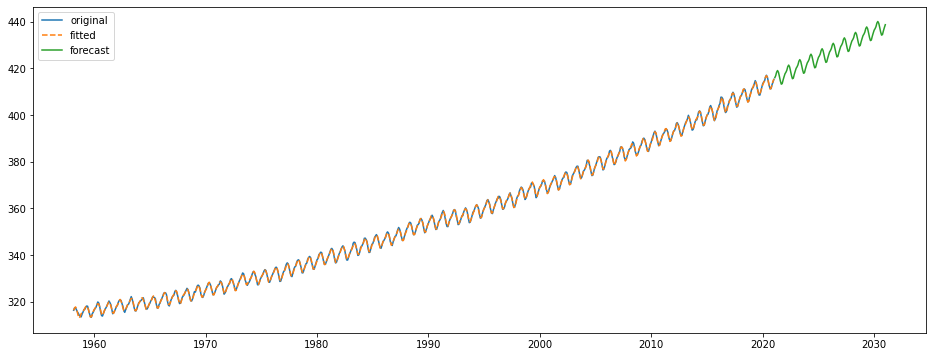

In [349]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(data["CO2"].index, data["CO2"].astype(float), label="original")
ax.plot(data["CO2"].index, result.fittedvalues, ls="dashed", label="fitted")
ax.plot(forecast.index, forecast.values, label="forecast")
leg = ax.legend()

Not bad! Later on we'll quantify what is meant by "bad" (or, ideally, "good" forecasts), but for now let's just admire this result by eye.

As mentioned, there are many varieties of exponential smoothing models, depending on their inclusion of trend and seasonal components, whether they're additively or multiplicatively combined, and whether the trend is damped (tl;dr: the forecast trend eventually goes to 0, so the forecast values eventually flatten out). For now, suffice to say that you can reproduce them by fiddling with the parameters of the `sm.tsa.ExponentialSmoothing()` class.

I should also note that, up to this point, all of our methods have produced "point" forecasts — that is, estimates of the central value at future times $t > T$ — but these can be misleading in the absence of forecast intervals that indicate the uncertainty on those values. There are ways to address this — for example, bootstrapping intervals from the percentiles of simulated, alternative forecasts using fitted residuals — but perhaps the nicest is just using an alternative statistical formulation of exponential smoothing that produces both point forecasts and intervals.

#### ETS models

Rather than exponential smoothing, the family of Error, Trend, Seasonal models rely on an underlying "state space" model that includes equations describing how the level, trend, and seasonal components (unobserved states) change over time. Each model may have additive or multiplicative errors.

For the state space formulation of simple exponential smoothing, one-step errors on the training data $e_{t}$ are modeled as normally and independently distributed values $\epsilon_{t} \sim \text{NID}(0, \sigma^{2})$, then the model is expressed like so:

- measurement (aka observation) equation: $y_{t} = \ell_{t - 1} + \epsilon_{t}$
- state (aka transition) equation: $\ell_{t} = \ell_{t - 1} + \alpha \epsilon_{t}$

Similar (but more complex) formulations can replicate the rest of the exponential smoothing family — plus prediction intervals. Nice!

In [357]:
model = sm.tsa.ETSModel(
    data["CO2"].astype(float),
    trend="add",
    seasonal="add",
    error="add",
    seasonal_periods=12,
    initialization_method="estimated",
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  755
Model:                       ETS(AAA)   Log Likelihood                -275.114
Date:                Tue, 02 Feb 2021   AIC                            586.229
Time:                        22:49:29   BIC                            669.510
Sample:                    03-01-1958   HQIC                           618.309
                         - 01-01-2021   Scale                            0.121
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5119      0.041     12.547      0.000       0.432       0.592
smoothing_trend         0.0067      0.002      3.077      0.002       0.002       0.011
smoothing_seasonal      0.0994      0.015      6.548      0.000       0.070       0.129
initial_level         316.3165   1476.532      0.214      0.830   -2577.633    3210.266
initial_trend           0.0725      0.030      2.455      0.014       0.015       0.130
initial_seasonal.0     -0.6357   1476.532     -0.000      1.000   -2894.585    2893.314
initial_seasonal.1     -1.2435   1476.532     -0.001      0.999   -2895.193    2892.706
initial_seasonal.2     -2.1422   1476.532     -0.001      0.999   -2896.091    2891.807
initial_seasonal.3     -3.1662   1476.532     -0.002      0.998   -2897.116    2890.783
initial_seasonal.4     -4.1498   1476.532     -0.003      0.998   -2898.099    2889.800
initial_seasonal.5     -4.1089   1476.532     -0.003      0.998   -2898.058    2889.841
initial_seasonal.6     -2.6394   1476.532     -0.002      0.999   -2896.589    2891.310
initial_seasonal.7     -0.7910   1476.532     -0.001      1.000   -2894.740    2893.158
initial_seasonal.8      0.6065   1476.532      0.000      1.000   -2893.343    2894.556
initial_seasonal.9      1.2417   1476.532      0.001      0.999   -2892.708    2895.191
initial_seasonal.10     0.8659   1476.532      0.001      1.000   -2893.083    2894.815
initial_seasonal.11          0   1476.532          0      1.000   -2893.949    2893.949
===================================================================================
Ljung-Box (Q):                       55.47   Jarque-Bera (JB):                12.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.04
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [358]:
# forecast = result.forecast(steps=120)
forecast = result.get_prediction(start="2021-02-01", end="2031-02-01").summary_frame(alpha=0.05)
forecast.head()

,mean,pi_lower,pi_upper
2021-02-01,416.023072,415.340319,416.705825
2021-03-01,416.837593,416.068497,417.606689
2021-04-01,418.390838,417.542242,419.239433
2021-05-01,419.083261,418.160218,420.006304
2021-06-01,418.304410,417.310814,419.298006


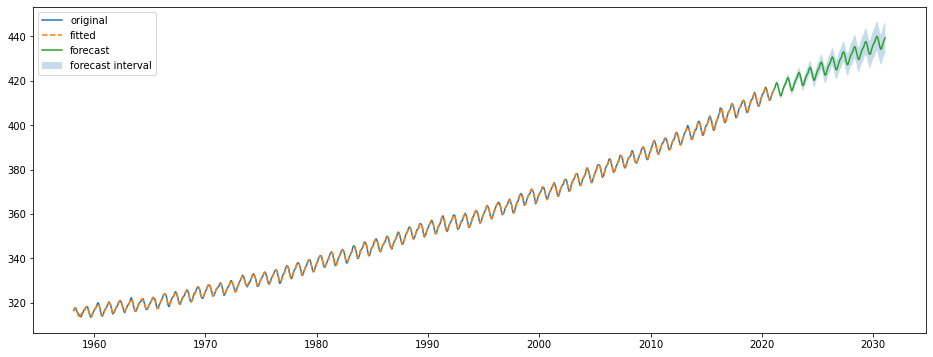

In [359]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(data["CO2"].index, data["CO2"].astype(float), label="original")
ax.plot(data["CO2"].index, result.fittedvalues, ls="dashed", label="fitted")
ax.fill_between(forecast.index, forecast["pi_upper"], forecast["pi_lower"], alpha=0.25, label="forecast interval")
ax.plot(forecast.index, forecast["mean"], label="forecast")
leg = ax.legend()

We can see that the prediction intervals get larger — there's more uncertainty — about forecast values farther out in time, but that the point forecast values look very similar to what we got with Holt-Winters.

### ARIMA and friends

### prophet, maybe?

### stationarity

a time series is stationary if its properties don't depend on time (e.g. constant mean and variance over time). a time series with cyclic behavior or white noise is staionary, but one with a changing trend or seasonality is not. it's important to check for stationarity because many forecasting models assume and only work for stationary data. fortunately, there are ways to transform time series into stationary data.

autocorrelation measures the (linear) relationship between _lagged_ values of a time series. for data with a trend component, autocorrelations for smaller lags tend to be larger because observations close in time are also close in magnitude; for data with a seasonal component, autocorrelations will be larger at multiples of the seasonal frequency. these effects may be combined, as below. for stationary time series, the ACF plot will quickly drop to ~0.

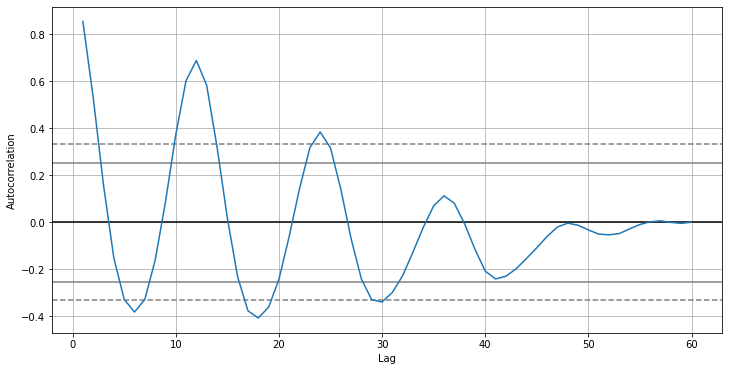

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = pd.plotting.autocorrelation_plot(data["CO2"].head(12 * 5), ax=ax)

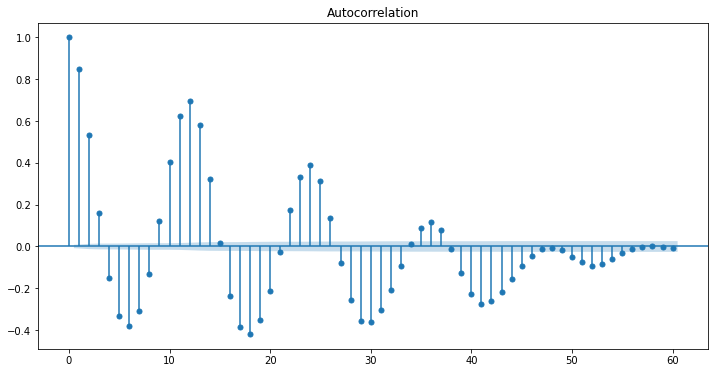

In [34]:
# note that both statsmodels and pandas include functionality for plotting autocorrelations
fig, ax = plt.subplots(figsize=(12, 6))
_ = sm.graphics.tsa.plot_acf(data["CO2"].head(12 * 5 + 1), lags=12 * 5, fft=True, alpha=0.95, use_vlines=True, ax=ax)

rather than just eye-balling it, we can also quantitatively assess a time series' stationarity.

In [35]:
sm.tsa.stattools.kpss(data["CO2"], nlags=12 * 5)  # nlags="auto")

/Users/burtondewilde/.pyenv/versions/3.9.1/envs/forecasting-study/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.327952836899965,
 0.01,
 60,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [36]:
sm.tsa.stattools.adfuller(data["CO2"])

(4.85346546470234,
 1.0,
 14,
 740,
 {'1%': -3.4392177416762086,
  '5%': -2.8654536415414684,
  '10%': -2.5688540485756026},
 642.0528733844808)

In [37]:
sm.tsa.stattools.q_stat(sm.tsa.stattools.acf(data["CO2"], fft=True), len(data["CO2"]))

/Users/burtondewilde/.pyenv/versions/3.9.1/envs/forecasting-study/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


(array([  758.00397878,  1509.61848971,  2253.27198947,  2988.5011137 ,
         3716.04348121,  4437.00941045,  5152.47171606,  5863.34064399,
         6570.60363587,  7275.26433784,  7978.04566278,  8678.6048878 ,
         9375.23318483, 10065.64183516, 10748.28682472, 11422.85338844,
        12090.11736783, 12751.07659983, 13406.64759607, 14057.67425861,
        14705.06797459, 15349.93128819, 15992.9517195 , 16633.79218714,
        17270.78993366, 17901.8103072 , 18525.43080444, 19141.36066467,
        19750.35098414, 20353.4226974 , 20951.40567151, 21545.03632598,
        22135.19573043, 22722.95127568, 23308.95834361, 23892.79817554,
        24472.97479073, 25047.46277014, 25614.85527597, 26174.90616848,
        26728.25323836]),
 array([7.29559352e-167, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0

#### differencing

take the difference between an observation and a lagged observation to remove time-dependent patterns in the data.

`difference(t) = observation(t) - observation(t - 1)` => first difference

`difference(t) = observation(t) - observation(t - N)` where `N` is the seasonality's period => seasonal differencing

differences can be applied multiple times, as needed. note that lag should be _interpretable_.

<AxesSubplot:xlabel='dt'>

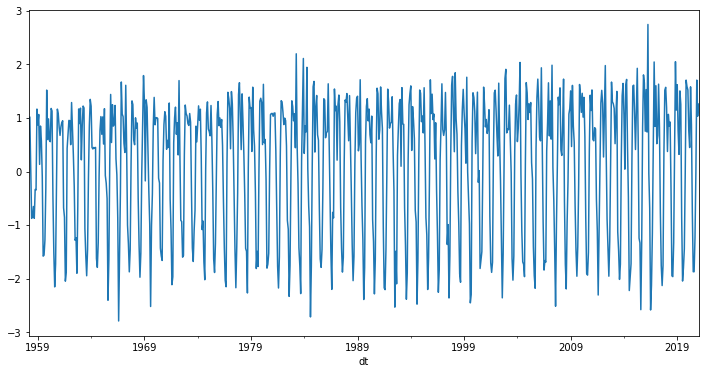

In [38]:
# first-order differencing
data["CO2"].diff(periods=1).plot.line(figsize=(12, 6))

<AxesSubplot:xlabel='dt'>

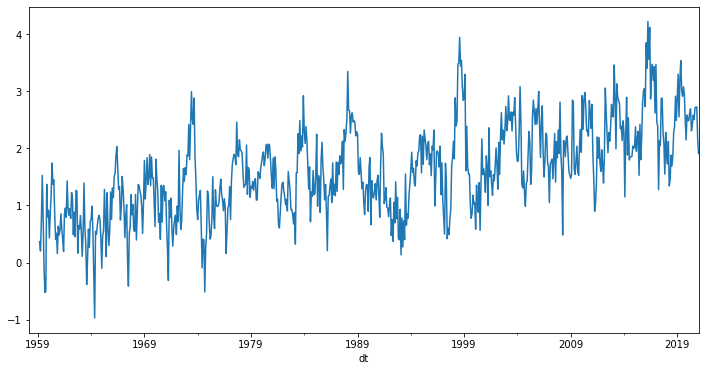

In [39]:
# seasonal differencing
data["CO2"].diff(periods=12).plot.line(figsize=(12, 6))

#### log transformation

another option is to transform the time series by taking the log

<AxesSubplot:xlabel='dt'>

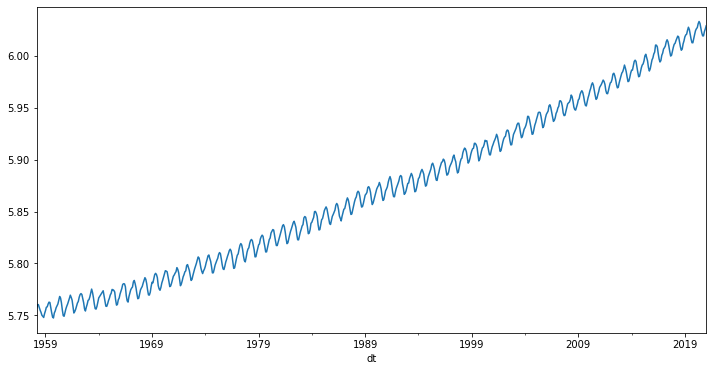

In [40]:
# hmm does this actually work?
data["CO2"].map(np.log).plot.line(figsize=(12, 6))